In [1]:
import sparknlp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
#create Spark session
spark = SparkSession.builder.appName('YelpML').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), ('spark.app.name', 'Spark Upadated Conf'), ('spark.executor.cores', '4'),('spark.cores.max', '4'), ('spark.driver.memory', '8g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.ui.proxyBase', '/proxy/application_1692206645525_0005'),
 ('spark.submit.pyFiles',
  '/root/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-4.4.0.jar,/root/.ivy2/jars/graphframes_graphframes-0.8.2-spark3.1-s_2.12.jar,/root/.ivy2/jars/com.typesafe_config-1.4.2.jar,/root/.ivy2/jars/org.rocksdb_rocksdbjni-6.29.5.jar,/root/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.828.jar,/root/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,/root/.ivy2/jars/com.google.cloud_google-cloud-storage-2.16.0.jar,/root/.ivy2/jars/com.navigamez_greex-1.0.jar,/root/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-cpu_2.12-0.4.4.jar,/root/.ivy2/jars/it.unimi.dsi_fastutil-7.0.12.jar,/root/.ivy2/jars/org.projectlombok_lombok-1.16.8.jar,/root/.ivy2/jars/com.google.guava_guava-31.1-jre.jar,/root/.ivy2/jars/com.google.guava_failureaccess-1.0.1.jar,/root/.ivy2/jars/com.google.guava_listenablefuture-99

In [59]:
# Import Data
dataDir = "gs://msca-bdp-student-gcs/group2/yelp-kaggleAPI/"
business = spark.read.json(dataDir + "yelp_academic_dataset_business.json")
review = spark.read.json(dataDir + "yelp_academic_dataset_review.json")
tip = spark.read.json(dataDir + "yelp_academic_dataset_tip.json")

## Overview

### Join review df and business df to find the category information for all kinds of businesses

In [78]:
review.show(5)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [79]:
review.count()

6990280

In [4]:
review = review.select('business_id', 'text', 'stars')

In [81]:
review.show(5)

+--------------------+--------------------+-----+
|         business_id|                text|stars|
+--------------------+--------------------+-----+
|XQfwVwDr-v0ZS3_Cb...|If you decide to ...|  3.0|
|7ATYjTIgM3jUlt4UM...|I've taken a lot ...|  5.0|
|YjUWPpI6HXG530lwP...|Family diner. Had...|  3.0|
|kxX2SOes4o-D3ZQBk...|Wow!  Yummy, diff...|  5.0|
|e4Vwtrqf-wpJfwesg...|Cute interior and...|  4.0|
+--------------------+--------------------+-----+
only showing top 5 rows



In [60]:
business = business.select('business_id', 'categories', 'stars')

In [83]:
business.show(5)

+--------------------+--------------------+-----+
|         business_id|          categories|stars|
+--------------------+--------------------+-----+
|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|  5.0|
|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|  3.0|
|tUFrWirKiKi_TAnsV...|Department Stores...|  3.5|
|MTSW4McQd7CbVtyjq...|Restaurants, Food...|  4.0|
|mWMc6_wTdE0EUBKIG...|Brewpubs, Breweri...|  4.5|
+--------------------+--------------------+-----+
only showing top 5 rows



In [61]:
from pyspark.sql.functions import explode, split
business = business.withColumn('categories_split', explode(split('categories', ', ')))

In [85]:
business.show()

+--------------------+--------------------+-----+--------------------+
|         business_id|          categories|stars|    categories_split|
+--------------------+--------------------+-----+--------------------+
|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|  5.0|             Doctors|
|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|  5.0|Traditional Chine...|
|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|  5.0|Naturopathic/Holi...|
|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|  5.0|         Acupuncture|
|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|  5.0|    Health & Medical|
|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|  5.0|       Nutritionists|
|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|  3.0|    Shipping Centers|
|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|  3.0|      Local Services|
|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|  3.0|            Notaries|
|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|  3.0|     Mailbox Centers|
|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|  3.0|   Printing Services|
|tUFrW

### Choose the reviews of restaurant category for furthur analysis

In [62]:
from pyspark.sql.functions import col
business = business.where(col('categories_split') == 'Restaurants').select('business_id', 'categories_split', 'stars')

In [63]:
# Save the stars column of business for future use
business2 = business

In [8]:
df = review.join(business, on = 'business_id', how = 'inner')

In [88]:
df.show(5)

+--------------------+--------------------+-----+----------------+
|         business_id|                text|stars|categories_split|
+--------------------+--------------------+-----+----------------+
|XQfwVwDr-v0ZS3_Cb...|If you decide to ...|  3.0|     Restaurants|
|YjUWPpI6HXG530lwP...|Family diner. Had...|  3.0|     Restaurants|
|kxX2SOes4o-D3ZQBk...|Wow!  Yummy, diff...|  5.0|     Restaurants|
|e4Vwtrqf-wpJfwesg...|Cute interior and...|  4.0|     Restaurants|
|04UD14gamNjLY0IDY...|I am a long term ...|  1.0|     Restaurants|
+--------------------+--------------------+-----+----------------+
only showing top 5 rows



In [89]:
df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- categories_split: string (nullable = true)



In [90]:
df.count()

4724471

In [9]:
df = df.repartition(100)

### Data Exploration

In [92]:
df1 = df.groupBy('stars').count().orderBy('stars', ascending = [1])

In [93]:
df1.show()

+-----+-------+
|stars|  count|
+-----+-------+
|  1.0| 567185|
|  2.0| 404486|
|  3.0| 543108|
|  4.0|1130251|
|  5.0|2079441|
+-----+-------+



In [94]:
pdf1 = df1.toPandas()

<AxesSubplot:xlabel='stars'>

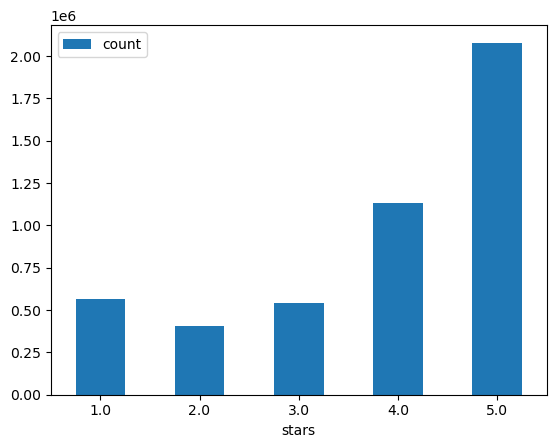

In [95]:
pdf1.plot(kind = 'bar', x = 'stars', y = 'count', rot = 360)

From the distribution of around 4.72 Millions restaurant review ratings, we observed a clear trend that 5-star reviews have the highest popularity compared to 4-star and 3-star. It's also clear that 1-star reviews are more prevalent compared to those with 2 or 3 stars.

So aligned with the observations, we had two assumptions. First, People often share their thoughts through reviews when they experience strong emotions. Second, people generally show a bias towards providing higher ratings unless their feelings towards a restaurant are especially negative. 

Thus, based on the two assumptions, we relabelled reviews with 4 stars or above positive, anything else is deemed to be negative.


### Relabelled the reviews to negative and positive

In [10]:
from pyspark.sql.functions import when
df = df.withColumn("label", when(df.stars >= 4, 1).otherwise(0))

In [97]:
df.show(5)

+--------------------+--------------------+-----+----------------+-----+
|         business_id|                text|stars|categories_split|label|
+--------------------+--------------------+-----+----------------+-----+
|fdjzXyPw1Zt2avRok...|I've been to the ...|  4.0|     Restaurants|    1|
|Bt7NBqA31uOI4H_hv...|Super cute small ...|  4.0|     Restaurants|    1|
|tCLAeZsjXFG9RumJ4...|Finally! I have b...|  4.0|     Restaurants|    1|
|GmJDCmDhtKbjofeO3...|I ordered food al...|  4.0|     Restaurants|    1|
|h4C7s_Go9UKo5twaL...|The food here is ...|  5.0|     Restaurants|    1|
+--------------------+--------------------+-----+----------------+-----+
only showing top 5 rows



In [98]:
df2 = df.groupBy('label').count().orderBy('count', ascending = [1])

In [99]:
df2.show()

+-----+-------+
|label|  count|
+-----+-------+
|    0|1514779|
|    1|3209692|
+-----+-------+



In [100]:
pdf2 = df2.toPandas()

<AxesSubplot:xlabel='label'>

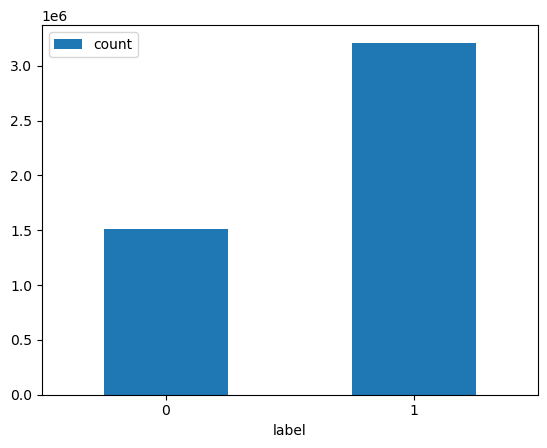

In [101]:
pdf2.plot(kind = 'bar', x = 'label', y = 'count', rot = 360)

### Create WeightCol for Imbalanced Data for Future Modeling

In [11]:
# Deal with imbalanced Data

from pyspark.sql import DataFrame
import pyspark.sql.types as T

def class_weights(df:DataFrame, column='label'):
  """
  Compute rebalancing weights for the given `column`.
  """
  class_counts = list(df.groupBy(column).count().toPandas().to_dict(orient='list').values())
  num_classes = len(class_counts[0])
  total_samples = sum(class_counts[1])
  pairs = list(zip(class_counts[0], class_counts[1]))
  return {k:total_samples/(num_classes * v) for (k, v) in pairs}

def weight_column(classes: pd.Series, class_weights) -> pd.Series:
  """
  UDF to compute class weights.
  Parameter `class_weights` is the pre-computed class_weights.
  Example call: sdf.withColumn('weight', weight_column(sdf['Class'], class_weights(sdf, column='Class')))
  """

  @F.pandas_udf(T.DoubleType())
  def weight_column_udf(classes: pd.Series) -> pd.Series:
    """
    UDF to compute rebalancing weights for the given `classes` (as a column).
    Depends on the within lexically scoped variable, class_weights, which contains a dictionary of weights.
    Relies on pre-computed class_weights (because cannot depend on pandas_udf to run over entire column in 1 batch)
    """
    result = []
    for _, value in classes.items():
      result += [class_weights[value]]
    return pd.Series(result)
  
  return weight_column_udf(classes)

In [12]:
print(f"The class weights are {class_weights(df)}")

The class weights are {1: 0.7359695260479822, 0: 1.5594588385500459}


In [13]:
df = df.withColumn('weight', weight_column(df['label'], class_weights(df)))

In [14]:
df = df.select('text', 'label', 'weight')

In [106]:
df.show(5)

+--------------------+-----+------------------+
|                text|label|            weight|
+--------------------+-----+------------------+
|I've been in Nash...|    1|0.7359695260479822|
|If you have never...|    1|0.7359695260479822|
|Got this for our ...|    0|1.5594588385500459|
|Food was okay. Or...|    0|1.5594588385500459|
|Great bar food an...|    1|0.7359695260479822|
+--------------------+-----+------------------+
only showing top 5 rows



In [109]:
# pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/5d/6b/011c4470fde93e2bfbe4cc1012077f6b96030124e3cd069b5500ad6e8b69/wordcloud-1.9.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 461.3/461.3 kB 9.9 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
df_positive = df.sample(0.01).filter(col('label') == 1)
df_negative = df.sample(0.01).filter(col('label') == 0)

(-0.5, 399.5, 199.5, -0.5)

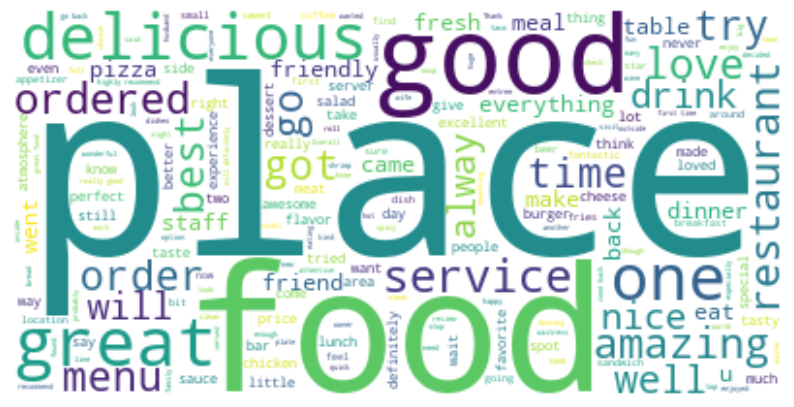

In [18]:
# Positive WordCloud
pos_lis = df_positive.select('text').collect()

pos_lis = ' '.join([pos_lis[i][0] for i in range(len(pos_lis))])

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(pos_lis)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

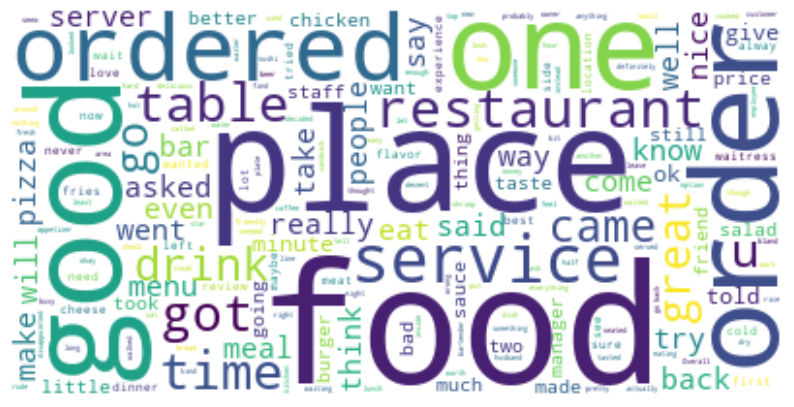

In [19]:
# Negative WordCloud
neg_lis = df_negative.select('text').collect()

neg_lis = ' '.join([neg_lis[i][0] for i in range(len(neg_lis))])

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(neg_lis)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

## Text Preprocessing

In [15]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import Word2Vec, HashingTF

In [17]:
# Initialize SparkNLP components
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

languageDetector = LanguageDetectorDL.pretrained() \
    .setInputCols("document") \
    .setOutputCol("language")

# Create a SparkNLP pipeline
pipeline1 = Pipeline(stages=[document_assembler, languageDetector])

ld_wiki_tatoeba_cnn_21 download started this may take some time.
Approximate size to download 7.1 MB
[OK!]


### Detect review languages

In [18]:
df_lang = pipeline1.fit(df).transform(df)
df_lang = df_lang.select("text", "label", "weight", "language.result")

In [24]:
df_lang.show(10)

+--------------------+-----+------------------+------+
|                text|label|            weight|result|
+--------------------+-----+------------------+------+
|I realize restaur...|    0|1.5594588385500459|  [en]|
|What a cute atmos...|    1|0.7359695260479822|  [en]|
|Impossible to cho...|    1|0.7359695260479822|  [en]|
|2/22/21 was Natio...|    1|0.7359695260479822|  [en]|
|Rude staff from
H...|    0|1.5594588385500459|  [en]|
|Came here with a ...|    0|1.5594588385500459|  [en]|
|This place is SO ...|    1|0.7359695260479822|  [en]|
|The food is  deli...|    0|1.5594588385500459|  [en]|
|Too overpriced fo...|    0|1.5594588385500459|  [en]|
|7/10 would bang a...|    1|0.7359695260479822|  [en]|
+--------------------+-----+------------------+------+
only showing top 10 rows



In [ ]:
df_lang.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: integer (nullable = false)
 |-- result: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [19]:
df3 = df_lang.groupBy('result').count().orderBy('count', ascending = [0])

In [ ]:
df3.show()

+---------+-------+
|   result|  count|
+---------+-------+
|     [en]|4718796|
|     [es]|   2210|
|     [fr]|    669|
|     [de]|    587|
|     [sl]|    520|
|     [da]|    501|
|     [it]|    280|
|     [pt]|    199|
|     [et]|    165|
|     [sv]|    164|
|     [nl]|    106|
|     [pl]|     90|
|     [ro]|     38|
|     [sk]|     38|
|     [fi]|     37|
|     [cs]|     36|
|     [lt]|     17|
|     [hu]|      7|
|[Unknown]|      5|
|     [el]|      4|
+---------+-------+
only showing top 20 rows



In [44]:
df3.cache()

DataFrame[result: array<string>, count: bigint]

In [21]:
from pyspark.sql.functions import array_contains

# Only keep the reviews written in English for future analysis
df_lang = df_lang.filter(array_contains(col("result"), "en"))

### Produce a final processed output

In [24]:
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized") \
    .setLowercase(True) \
    .setCleanupPatterns(["""[^\w\d\s]"""])

lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(["normalized"]) \
    .setOutputCol("lemmatized")

finisher = Finisher() \
    .setInputCols(['lemmatized']) \
    .setOutputCols(["finished"])

hashingTF = HashingTF() \
    .setInputCol("finished") \
    .setOutputCol("features")

pipeline2 = Pipeline(stages=[document_assembler, tokenizer, normalizer, lemmatizer, finisher, hashingTF])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [23]:
pipeline_model = pipeline2.fit(df_lang)
encodedData = pipeline_model.transform(df_lang)

In [25]:
encodedData = encodedData.select('text', 'label', 'weight', 'features')

In [26]:
encodedData.cache()

DataFrame[text: string, label: int, weight: double, features: vector]

## Classification Models

In [27]:
#spark ML imports
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier, RandomForestClassificationModel

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [28]:
#split data into train and test
train_df, test_df = encodedData.randomSplit([.8,.2],seed = 16)

### LinearSVC

In [83]:
svm = LinearSVC().\
        setLabelCol('label').\
        setFeaturesCol('features').\
        setWeightCol('weight').\
        setMaxIter(5)

In [85]:
svmModel = svm.fit(train_df)
svm_pred = svmModel.transform(test_df)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print("accuracy:", round(evaluator.evaluate(svm_pred, {evaluator.metricName: "accuracy"}), 4))
print("f1:", round(evaluator.evaluate(svm_pred, {evaluator.metricName: "f1"}), 4))

23/08/17 04:56:22 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/17 04:56:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB


accuracy: 0.8977
f1: 0.8981


In [86]:
svm_train = svmModel.transform(train_df)
accuracy_train = evaluator.evaluate(svm_train, {evaluator.metricName: "accuracy"})
f1_train = evaluator.evaluate(svm_train, {evaluator.metricName: "f1"})

23/08/17 04:58:38 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/17 04:58:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB


In [88]:
print("Training accuracy:", round(accuracy_train, 4))
print("Training F1 score:", round(f1_train, 4))

Training accuracy: 0.9034
Training F1 score: 0.9038


23/08/17 01:33:01 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/17 01:33:03 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB


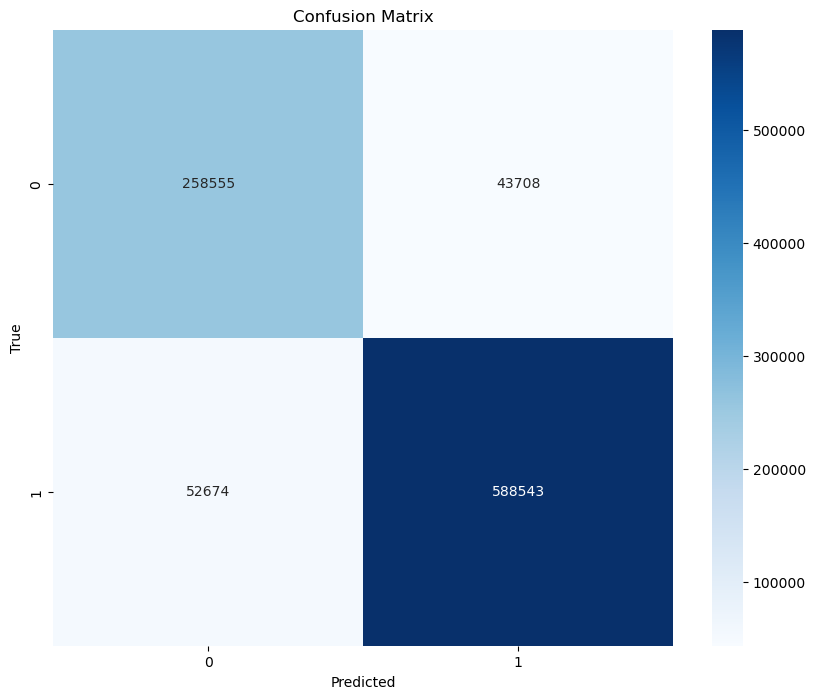

In [61]:
# Calculate the confusion matrix
confusion_matrix = svm_pred.groupBy("label", "prediction").count().toPandas()

# Convert the confusion matrix to a matrix format for plotting
num_classes = len(confusion_matrix['label'].unique())
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

for _, row in confusion_matrix.iterrows():
    true_label = int(row['label'])
    predicted_label = int(row['prediction'])
    count = row['count']
    conf_matrix[true_label][predicted_label] = count

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"{i}" for i in range(num_classes)],
            yticklabels=[f"{i}" for i in range(num_classes)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

plt.show()

### Hyperparameter Tuning

In [29]:
svm = LinearSVC() \
    .setLabelCol('label') \
    .setFeaturesCol('features') \
    .setWeightCol('weight') \
    .setMaxIter(5)

# Define the parameter grid for tuning
param_grid = (ParamGridBuilder()
              .addGrid(svm.regParam, [0.01, 0.1, 1.0])  
              .build())

# Define the CrossValidator
cv = CrossValidator(estimator=svm,
                    estimatorParamMaps=param_grid,
                    evaluator=BinaryClassificationEvaluator(),
                    numFolds=3)  # Number of folds for cross-validation

In [ ]:
# Fit the CrossValidator on the training data
cv_model = cv.fit(train_df)
# Get the best model from CrossValidator
best_model = cv_model.bestModel

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)
23/08/17 03:50:17 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/08/17 03:50:17 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/08/17 03:50:27 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/17 03:50:47 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/17 03:51:01 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task 

In [31]:
model_path = f"msca-bdp-student-gcs/group2/yelp-model/Tune_Model"
best_model.save(model_path)

23/08/17 04:01:26 WARN org.apache.spark.scheduler.TaskSetManager: Stage 533 contains a task of very large size (2094 KiB). The maximum recommended task size is 1000 KiB.


In [32]:
# Get the best parameters
best_params = best_model.extractParamMap()

print("Best parameters:")
for param in best_params:
    print(f"{param.name}: {best_params[param]}")

Best parameters:
aggregationDepth: 2
featuresCol: features
fitIntercept: True
labelCol: label
maxBlockSizeInMB: 0.0
maxIter: 5
predictionCol: prediction
rawPredictionCol: rawPrediction
regParam: 0.01
standardization: True
threshold: 0.0
tol: 1e-06
weightCol: weight


In [33]:
best_pred = best_model.transform(test_df)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print("accuracy:", round(evaluator.evaluate(best_pred, {evaluator.metricName: "accuracy"}), 4))
print("f1:", round(evaluator.evaluate(best_pred, {evaluator.metricName: "f1"}), 4))

23/08/17 04:01:46 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/17 04:01:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB


accuracy: 0.8978


f1: 0.8982


In [80]:
best_train = best_model.transform(train_df)
accuracy_train = evaluator.evaluate(best_train, {evaluator.metricName: "accuracy"})
f1_train = evaluator.evaluate(best_train, {evaluator.metricName: "f1"})

23/08/17 04:53:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/17 04:53:26 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB


In [82]:
print("Training accuracy:", round(accuracy_train, 4))
print("Training F1 score:", round(f1_train, 4))

Training accuracy: 0.9034
Training F1 score: 0.9038


23/08/17 04:02:01 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/17 04:02:03 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB


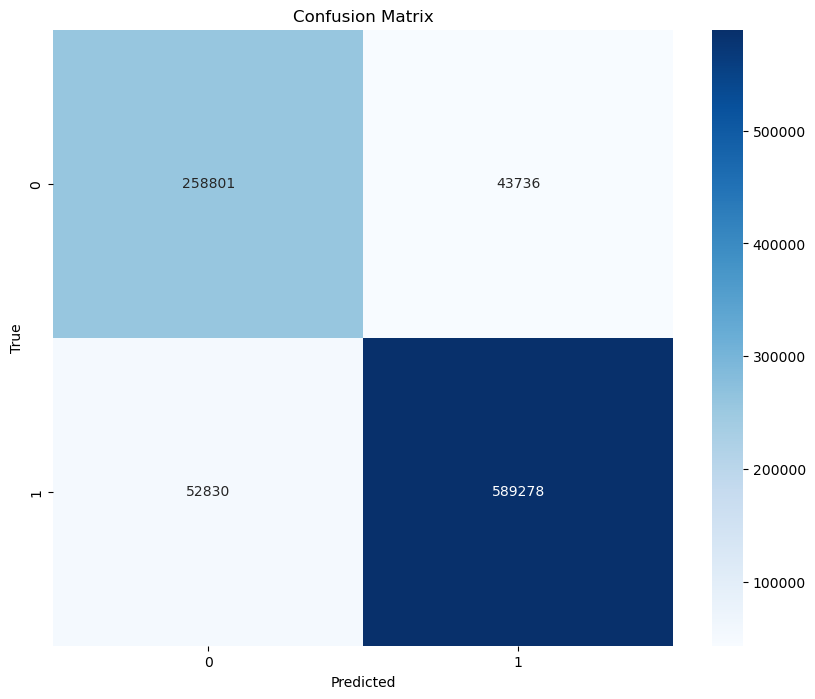

In [34]:
# Calculate the confusion matrix
confusion_matrix = best_pred.groupBy("label", "prediction").count().toPandas()

# Convert the confusion matrix to a matrix format for plotting
num_classes = len(confusion_matrix['label'].unique())
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

for _, row in confusion_matrix.iterrows():
    true_label = int(row['label'])
    predicted_label = int(row['prediction'])
    count = row['count']
    conf_matrix[true_label][predicted_label] = count

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"{i}" for i in range(num_classes)],
            yticklabels=[f"{i}" for i in range(num_classes)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

plt.show()

### Predict Sentiment for Tips Data

#### Preprocessing

In [35]:
tip.show(5, truncate = False)

+----------------------+----------------+-------------------+---------------------------------------------------------+----------------------+
|business_id           |compliment_count|date               |text                                                     |user_id               |
+----------------------+----------------+-------------------+---------------------------------------------------------+----------------------+
|3uLgwr0qeCNMjKenHJwPGQ|0               |2012-05-18 02:17:21|Avengers time with the ladies.                           |AGNUgVwnZUey3gcPCJ76iw|
|QoezRbYQncpRqyrLH6Iqjg|0               |2013-02-05 18:35:10|They have lots of good deserts and tasty cuban sandwiches|NBN4MgHP9D3cw--SnauTkA|
|MYoRNLb5chwjQe3c_k37Gg|0               |2013-08-18 00:56:08|It's open even when you think it isn't                   |-copOvldyKh1qr-vzkDEvw|
|hV-bABTK-glh5wj31ps_Jw|0               |2017-06-27 23:05:38|Very decent fried chicken                                |FjMQVZjSqY8syIO-53KFKw|

In [64]:
tip_join = tip.join(business2, on = 'business_id', how = 'inner')

In [65]:
tip_join.count()

649150

In [66]:
tip_lang = pipeline1.fit(tip_join).transform(tip_join)

tip_lang = tip_lang.select("business_id", "text", "language.result")

# Only keep the reviews written in English for future analysis
tip_lang = tip_lang.filter(array_contains(col("result"), "en"))

In [37]:
tip_lang.show()

+--------------------+--------------------+------+
|         business_id|                text|result|
+--------------------+--------------------+------+
|-ib2qJmDKJgH_ZbtS...|My favorite pizza...|  [en]|
|rTXNiH-RROF1OQHVI...|Everything is gre...|  [en]|
|1Z9y1CQj1BZjdFJGu...|Having a good tim...|  [en]|
|qUSrh_Zya0O1sRffR...|        Soccer party|  [en]|
|jziRKhtHxeJPAPWS2...|Sit at the Bar......|  [en]|
|5dHjoqaoVAhpVuQeM...|Lunch special is ...|  [en]|
|ytHIl7I5KNSzpzArw...|Check Groupon for...|  [en]|
|pjpuqrBvweu94n1zZ...|Carmelfest & Fire...|  [en]|
|50QTrfSrow-F2Avsj...|Wonderful service...|  [en]|
|vl4uDnmI6lM9zBcAR...|Best BBQ I've had...|  [en]|
|mQc4BBUzR9xyLbUTL...|Great service for...|  [en]|
|RJsiOi9v9POOn83yb...|Got the Monday Af...|  [en]|
|ecGqst5qksmuh9qIm...|   Gross soggy pizza|  [en]|
|sy7ADvpBA7SfHwbY-...|Best happy hour s...|  [en]|
|8O35ji_yOMVJmZ6bl...|The line to go th...|  [en]|
|1WwrdoWB8hY-WDA2Y...|Always a good go ...|  [en]|
|SDV-haafzhoRqW9d_...|Authentic

In [67]:
tip_encodedData = pipeline_model.transform(tip_lang)
tip_encodedData = tip_encodedData.select("business_id", 'text', 'features')

In [47]:
tip_encodedData.show(5)

+--------------------+--------------------+--------------------+
|         business_id|                text|            features|
+--------------------+--------------------+--------------------+
|-ib2qJmDKJgH_ZbtS...|My favorite pizza...|(262144,[19036,19...|
|rTXNiH-RROF1OQHVI...|Everything is gre...|(262144,[33917,79...|
|1Z9y1CQj1BZjdFJGu...|Having a good tim...|(262144,[33053,74...|
|qUSrh_Zya0O1sRffR...|        Soccer party|(262144,[127058,1...|
|jziRKhtHxeJPAPWS2...|Sit at the Bar......|(262144,[5923,404...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [41]:
#loaded_model = LinearSVCModel.load(model_path)
tip_pred = best_model.transform(tip_encodedData)

In [68]:
from pyspark.ml.classification import LinearSVCModel
loaded_model = LinearSVCModel.load(model_path)
tip_pred = loaded_model.transform(tip_encodedData)

In [69]:
tip_pred = tip_pred.drop('features')

In [70]:
tip_pred.show(truncate = False)

23/08/17 04:21:26 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB


+----------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------+----------+
|business_id           |text                                                                                                                                                                                                                       |rawPrediction                                 |prediction|
+----------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------+----------+
|QoezRbYQncpRqyrLH6Iqjg|They have lots of good deserts and tasty cuban sandwiches          

In [71]:
tip_pred.groupBy('prediction').count().show()

23/08/17 04:22:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/17 04:24:10 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/17 04:24:10 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB


+----------+------+
|prediction| count|
+----------+------+
|       0.0|149229|
|       1.0|471770|
+----------+------+



In [90]:
tip_pred.filter(col('prediction') == 0).drop('business_id', 'rawPrediction').show(20, truncate = False)

23/08/17 08:01:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB


+---------------------------------------------------------------------------------------------------------------------------------------------+----------+
|text                                                                                                                                         |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------+----------+
|It's open even when you think it isn't                                                                                                       |0.0       |
|Very decent fried chicken                                                                                                                    |0.0       |
|Chili Cup + Single Cheeseburger with onion, pickle, and relish + Vanilla Coca-Cola...so far.                                                 |0.0       |
|Starbucks substitute in boring downtown Tampa. Ugh. Never again!     

In [73]:
tip_pred.filter(col('prediction') == 1).drop('business_id', 'rawPrediction').show(20, truncate = False)

23/08/17 04:25:16 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|text                                                                                                                                                                                                                       |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|They have lots of good deserts and tasty cuban sandwiches                                                                                                                                                                  |1.0       |
|Appetizers.. platter special for lunch                             

In [74]:
from pyspark.sql import functions as F

df4 = tip_pred.groupBy('business_id').agg(
    F.count('business_id').alias('business_count'), 
    F.round(F.avg('prediction'), 4).alias('avg_prediction_rounded')
).orderBy('business_count', 'avg_prediction_rounded', ascending=[0])

In [53]:
df4.show()

23/08/17 04:09:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/17 04:11:35 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB


+--------------------+--------------+----------------------+
|         business_id|business_count|avg_prediction_rounded|
+--------------------+--------------+----------------------+
|FEXhWNCMkv22qG04E...|          2393|                0.6912|
|_ab50qdWOk0DdB6XO...|           904|                0.7965|
|ytynqOUb3hjKeJfRj...|           789|                0.8707|
|ac1AeYqs8Z4_e2X5M...|           597|                0.8224|
|GBTPC53ZrG1ZBY3DT...|           586|                0.8242|
|iSRTaT9WngzB8JJ2Y...|           577|                0.7036|
|GXFMD0Z4jEVZBCsbP...|           559|                0.7531|
|I_3LMZ_1m2mzR0oLI...|           537|                0.7486|
|QHWYlmVbLC3K6eglW...|           534|                0.8202|
|oBNrLz4EDhiscSlbO...|           525|                0.7752|
|gTC8IQ_i8zXytWSly...|           509|                0.8762|
|VQcCL9PiNL_wkGf-u...|           501|                0.7844|
|yPSejq3_erxo9zdVY...|           490|                0.8531|
|RQAF6a0akMiot5lZZ...|  

In [75]:
df5 = df4.join(business2, on = 'business_id', how = 'inner')

In [76]:
df5.orderBy('business_count', ascending=[0]).show()

23/08/17 04:25:52 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/17 04:27:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB


+--------------------+--------------+----------------------+----------------+-----+
|         business_id|business_count|avg_prediction_rounded|categories_split|stars|
+--------------------+--------------+----------------------+----------------+-----+
|FEXhWNCMkv22qG04E...|          2393|                0.6912|     Restaurants|  4.0|
|_ab50qdWOk0DdB6XO...|           904|                0.7965|     Restaurants|  4.0|
|ytynqOUb3hjKeJfRj...|           789|                0.8707|     Restaurants|  4.5|
|ac1AeYqs8Z4_e2X5M...|           597|                0.8224|     Restaurants|  4.0|
|GBTPC53ZrG1ZBY3DT...|           586|                0.8242|     Restaurants|  4.0|
|iSRTaT9WngzB8JJ2Y...|           577|                0.7036|     Restaurants|  3.5|
|GXFMD0Z4jEVZBCsbP...|           559|                0.7531|     Restaurants|  4.5|
|I_3LMZ_1m2mzR0oLI...|           537|                0.7486|     Restaurants|  4.5|
|QHWYlmVbLC3K6eglW...|           534|                0.8202|     Restaurants